# STI Sector Revision Strategy

Alrighty, I have an idea that I want to try out. Basically, we would like to conduct a backtest on different Singapore sectors and see if we can leverage upon a mean-reversion strategy. 

The basic idea is to rank these stocks based on their past 12 returns. After which, we will long the worst performing sector and short the best performing sector. We will also examine a variety of holding periods including 1 month, 3 months, 6 months and 12 months. Subsequently, we will compare the performance of our strategy to the STI index. 

## Processing the data

First, we have downloaded the data from STI. We will need to write a couple of helper functions to process our data before we can pass it into our backtester.

In [1]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata

The first step is to read our downloaded data.

In [2]:
def get_yahoo_data(names, tickers, start, end):
    # Pass in a list of stock tickers together with a list of user defined stock names
    # the function will fetch the daily OHLC data of that stock ticker from yahoo and 
    # return it in a dictionary with the name as the key, and the daily stock data 
    # in a dataframe as the value.
    
    # Override existing pandas yahoo api
    yf.pdr_override()
    
    # Create an empty dictionary
    d = {}
    
    # Reindex our columns
    cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    
    # Iterate through the names and tickers
    for name, ticker in zip(names, tickers):
        df = pdr.get_data_yahoo(ticker, start=start, 
                                  end=end)
        df = df.reindex(columns=cols)
        d[name] = df
    
    return d

Next, we would like to ensure that our data has the same working timeframe. In order to accomplish this, we will be standardizing our index according to the business day calendar.

In [3]:
def standardize_index(raw_dict, start, end, method='ffill'):
    # Pass in a dictionary, with the keys as the stock names and values
    # as the stock daily data. This function will create a master index from the
    # start date till the end date with the list of all business days, and standardize 
    # the datetime index for all the other stocks. Moreover, by default, this function will apply forward fill
    # for all the missing values in the dataframe after the start date of that particular
    # stock data.
    
    # Create a new dictionary
    d = {}
    
    # Create a master index 
    master_index = pd.date_range(start, end, freq='B')
    
    for key in raw_dict.keys():
        # Get the starting day index of the stock (i.e. the day it started trading)
        start_date_index = raw_dict[key].index[0]
        
        # Standardize the index
        d[key] = raw_dict[key].reindex(master_index)
        d[key].sort_index(inplace=True)
            
        # Seperate the dataframe into two seperate dataframe, before start date and after
        # start date. For the dates after the start date, if there are NaN values, we will 
        # be using the method specified to fill in the values
        before = d[key].loc[:start_date_index]
        after = d[key].loc[start_date_index + BDay(1):]
        after.fillna(method=method, inplace=True)
        # Concatenate the matrices and assign them accordingly
        d[key] = pd.concat([before, after]).copy()
    
    return d

Next, we will look to calculate the cumulative returns. Note that for MOM 12-2, we will be calculating the absolute return from the last 12 month to the last 2 month. 

To do so, we will first resample the data and change it into a monthly timeframe before performing our calulation. Do note that we will be performing our calculations based on the end of month adjusted prices.

In [4]:
def lookback_returns(raw_dict, n, m, col='Adj Close'):
    # Pass in a raw dictionary and specify the lookback_period in months. This
    # function will calculate the M(lookback_period) - 12 cumulative returns
    # and return it in a dataframe with the same dimensions

    # Create a new dictionary
    d = {}
    
    # Create a empty dataframe to store all the returns
    returns = pd.DataFrame()
    
    # Resampling our daily data into monthly timeframe (end of month)
    for key in raw_dict.keys():
        d[key] = raw_dict[key].resample('M').last()

        # Caculate the n lookback monthly returns using Adjusted Close (note returns 
        # are calculated using end of month data)
        returns[key] = (d[key][col].shift(m-1) / d[key][col].shift(n)) - 1
    
    return returns

After calculating the cumulative returns, the next step would be to rank the stocks accordingly.

In [5]:
def rank_returns(returns_dict):
    # Pass in a raw dictioary specifying the lookback_returns of the stocks. The
    # function will rank them accordingly and return a dataframe of the same dimension
    # with the ranking for each row

    # Use rankdata and apply_along_axis to create a np matrix of rankings
    rank = np.apply_along_axis(rankdata, 1, returns_dict)
    
    # Put the rankings into a pandas dataframe
    ranked_returns = pd.DataFrame(rank, columns=returns_dict.columns,
                                 index=returns_dict.index)
    
    return ranked_returns

In [6]:
def top_percentile_rank_returns(returns_dict, n):
    # Pass in a raw dictionary specificying the returns of the stocks, with the names of the stock
    # as the column headers. This function will rank them accordingly and for the top n percentile
    # of stocks, the function will return 1 and 0 otherwise. 
    
    # Get a dataframe of the returns ranking
    ranked_returns = rank_returns(returns_dict)
    
    # Get a panda series of the count
    count = returns_dict.count(axis=1)
    
    # Label the top n percentile of stocks with 1 and 0 for the rest
    top_percentile_ranked_returns = ranked_returns.apply(lambda x: x <= np.round(n*count)).astype('int')
    
    # Change the date to the start of the month
    top_percentile_ranked_returns.index = top_percentile_ranked_returns.index - pd.DateOffset(day=1)
    
    # Lag the signal by one month
    top_percentile_ranked_returns = top_percentile_ranked_returns.shift(1)
    
    return top_percentile_ranked_returns

Now at this juncture, our function will calculate the cumulative returns for our stocks and rank them accordingly. After which, it will create a new columns called 'Signal', which will only accept a binary value, with 1 indicating that it should be in our portfolio at the start of that particular month, and 0 otherwise.

Now, for every stock, we will merge the 'Signal' column with the initial dataframe.

In [7]:
def create_signal(raw_dict, top_p_ranked_returns):
    # Pass in a raw dictionary with the keys as the stock names and the values as a pandas
    # dataframe containing the stocks daily values, as well as a result providing the 
    # name of the stocks with the best past x months return. This function will return the 
    # raw dictionary dataframe with a new binary column 'signal', with 1 indicating a long 
    # position and -1 indicating a short position
    
    # Create an empty dictionary to store our final output
    d = {}
    
    # Refer to the master index
    master_index = list(raw_dict.values())[0].index
    
    # Use forward fill to extend the montly ranking series to daily serires
    master_index.name = 'date'
    top_p_ranked_returns = top_p_ranked_returns.reindex(master_index, method='ffill')
    
    # Merge the rankings with the original stock dataframe and rename it as signal
    for key in raw_dict.keys():
        signal = top_p_ranked_returns[key]
        signal.name = 'Signal'
        d[key] = raw_dict[key].join(signal, how='inner')
    
    return d

Next, we will adjust the Open, High, Low and Volume according to the Adj Close provided by yahoo finance to account for any dividends and splits that took place.

In [8]:
def adj_yahoo_data(raw_dict):
    # Pass in raw unadjusted yahoo data as well as Adj Close prices. This function
    # will adjust the Open, High, Low and Volume column according to the Adj Close prices
    
    # create a new dictionary
    d = {}
    
    for key in raw_dict.keys():
        # Calculate the params to adjust OHLC prices 
        param = raw_dict[key]['Adj Close'] / raw_dict[key]['Close']
        d[key] = raw_dict[key].copy()

        d[key][['Open', 'High', 'Low']] = d[key][['Open', 'High', 'Low']].mul(param, 
                                                                                  axis=0)
        # Drop the column close and rename Adj Close as Close
        d[key].drop(['Close'], axis=1, inplace=True)
        d[key].rename({'Adj Close' : 'Close'}, axis='columns', inplace=True)
    
        # Fill the NaNs with 0 to load into our backtrader
        d[key].fillna(0, inplace=True)
        
    return d

Finally, we will include a helper function to shift the period of our reits data to our desired backtesting period.

In [9]:
def adjust_backtest_dates(raw_dict, start, end):
    
    # Create a new dictionary
    d = {}
    
    for key in raw_dict.keys():
        d[key] = raw_dict[key].loc[start:end]
    
    return d

## Pyfolio

Now, let's import pyfolio and create our custom tear sheet. This will be very useful when we want to showcase our backtesting results later on.

In [10]:
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def create_custom_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.
    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    returns = returns[returns.index > benchmark_rets.index[0]]

    pf.show_perf_stats(returns, benchmark_rets)

    pf.show_worst_drawdown_periods(returns)

    # If the strategy's history is longer than the benchmark's, limit strategy
    if returns.index[0] < benchmark_rets.index[0]:
        returns = returns[returns.index > benchmark_rets.index[0]]

    vertical_sections = 12

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=True,
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    pf.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    pf.plot_rolling_beta(
        returns, benchmark_rets, ax=ax_rolling_beta)

    pf.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    pf.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    pf.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    pf.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    pf.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    pf.plot_annual_returns(returns, ax=ax_annual_returns)
    pf.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    pf.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap:
        ax_bootstrap = plt.subplot(gs[i, :])
        pf.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


## Backtesting our strategy

Now that we have written our helper functions, it is time to specify the names of our stocks, their respective tickers as well as the start date and end date for our data. Below, we have chosen a total of 36 reits + 22 STI stocks listed in Singapore who are denominated in SGD, and we have chosen to download the data from June 2009 to January 2018.

In [11]:
# Load the packages neccessary to run backtrader
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.filters as btfilters

%matplotlib inline

In [12]:
names = ['Basic Materials', 'Consumer Goods', 'Consumer Services', 'Financials',
         'Healthcare', 'Industrials', 'Maritime', 'Oil & Gas', 'Real Estate',
         'Real Estate', 'Technology', 'Telecommunications', 'Utilities']

# Create an empty dictionary to store our raw data
data_raw = {} 

# Create a dictionary with our raw data
for name in names:
    filename = 'C:\\Users\\Law Wen Yu\\.jupyter\\data\\STI Sector Indicies\\' + name + ".csv"
    file = pd.read_csv(filename, index_col = 0, header=0)
    file['Adj Close'] = file['Close']
    file.index = pd.to_datetime(file.index)
    data_raw[name] = file

In [13]:
# Get the index data for our backtest
index_name = ['STI']
index_ticker = ['ES3.SI']

start = '2013-01-01'
end = '2018-01-31'

# Time to use our helper functions
index_raw = get_yahoo_data(names=index_name, tickers=index_ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 downloaded


In [14]:
# Standardize the index
data_standardized = standardize_index(data_raw, start=start, end=end)
index_standardized = standardize_index(index_raw, start=start, end=end)

In [15]:
# Drop the volume column
index_raw['STI'].drop(labels='Volume', axis=1, inplace=True)

In [67]:
from collections import OrderedDict

# Set the top 10 percentile of stocks to be included in our portfolio 
n = 0.2

# Start date and end date of backtest
bt_start_date = '2014-12-31'
bt_end_date = '2018-01-31'

# Set the lookback_period to calculate the past returns
lookback_period = [(12, 1), (12, 2), (12, 7), (6, 1), (6, 2)]

# Create lists to store our raw_data
raw_datas_names = ['MOM 12-1', 'MOM 12-2', 'MOM 12-7', 'MOM 6-1', 'MOM 6-2']
raw_datas = []

# Loop through all the variation that we want to test
for i, j in lookback_period:
    # Calculate the returns based on the lookback period
    data_returns = lookback_returns(data_standardized, i, j)
    
    # Rank the stocks returns accordingly
    top_p_rank_returns = top_percentile_rank_returns(data_returns, n)
    bottom_p_rank_returns = top_percentile_rank_returns(-data_returns, n)
    
    # Long the best performer
    combined_p_rank_returns = top_p_rank_returns
    
    # Create the long and short signal for each respective sector
    data = create_signal(data_standardized, combined_p_rank_returns)
    
    # Adjust the data accordingly using the adjusted returns
    adj_data = adj_yahoo_data(data)
    
    # Adjust the data to the start and end of the backtest dates
    sector_backtest_data = adjust_backtest_dates(adj_data, bt_start_date, bt_end_date)
    raw_datas.append(sector_backtest_data)
    
# Create an ordered dictionary storing all our processed data
full_raw_dict = OrderedDict(zip(raw_datas_names, raw_datas))

In [68]:
# Adjust the index for splits and dividends accordingly
adj_index = adj_yahoo_data(index_standardized)
index_backtest_data = adjust_backtest_dates(adj_index, bt_start_date, bt_end_date)

In [69]:
# Create a custom extended PandasData feed 
class CustomDataLoader(bt.feeds.PandasData):
    lines = ('signal',)
    params = (('signal', -1), # Set the expected position of the column 'Signal'
             )
    
    datafields = bt.feeds.PandasData.datafields + (['Signal'])

In [70]:
# Define our NewMomentum Strategy 
class NewMomentumStrategy(bt.Strategy):
    params = (('period', 1), 
             ('lpositions', 1),
              ('spositions', 1),
             )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        
    def notify_order(self, order):
        if order.status == order.Completed:
            n = order.info.name
            size = order.size
            if order.isbuy():
                self.log('Buy ' + str(size) + ' ' + str(n))
                
            else:
                self.log('Sell ' + str(-size) + ' ' + str(n))
        
        elif order.status == order.Rejected:
            self.log('Order is rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def start(self):
        self.order = None
    
    def next(self):

        #start of backtesting period
        b_test_start = '12/31/2014'
        
        # end of backtesting period
        b_test_end = '1/1/2018'
        
        # End of the business month for Singapore timezone to rebalance 
        # our portfolio (vary from 1Q, 2Q, 4Q)
        end_date_range = pd.date_range(b_test_start, b_test_end, 
                                   freq='BM', tz='Asia/Singapore')[::self.p.period]
    
        # We will be rebalancing our portfolio according to the period specified
        if self.datas[0].datetime.date(0) in end_date_range:
            # Simply log the closing price of the series from the reference
            self.log('Close ' + '%.2f '*len(self.datas) % (tuple(self.datas[i].close[0]
                                                            for i in range(len(self.datas)))))
            
            # log the positions
            self.log('Current Positions: '+ '%d '*len(self.datas) % tuple([self.getposition(self.datas[i]).size 
                                          for i in range(len(self.datas))]))
            
            # list of stocks to buy 
            target_buy = [i for i in range(len(self.datas)) if self.datas[i].signal[1] > 0]
            
            # list of stocks to short
            target_short = [i for i in range(len(self.datas)) if self.datas[i].signal[1] < 0]
            
            # Log the number of stocks to be bought
            self.p.lpositions = len(target_buy)
            
            # Log the number of stocks to be sold
            self.p.spositions = len(target_short)
            
            # list of stocks to sell
            target_sale = [i for i in range(len(self.datas)) if i not in target_buy+target_short]                                    
            
            for j in target_sale:
                # if there is an existing position, sell the stock
                if not self.getposition(self.datas[j]).size == 0:
                    self.order = self.order_target_size(target=0, 
                                                        data=self.datas[j])
                    if self.order is not None:
                        self.order.addinfo(name=self.datas[j]._name)
                        
            for i in target_buy:
                # buy the stock according to the number of stocks in our target_buy list
                self.order = self.order_target_percent(target=np.round(1.0/self.p.lpositions, 2), 
                                                          data=self.datas[i],
                                                      price=self.datas[i].high[1],
                                                       exectype=bt.Order.Limit)
                if self.order is not None:
                    self.order.addinfo(name=self.datas[i]._name)
                    
            for i in target_short:
                # short the stock according to the number of stocks in our target_short list
                self.order = self.order_target_percent(target=-np.round(1.0/self.p.spositions, 2), 
                                                          data=self.datas[i],
                                                      price=self.datas[i].high[1],
                                                       exectype=bt.Order.Limit)
                if self.order is not None:
                    self.order.addinfo(name=self.datas[i]._name)

Starting Portfolio Value: 100000.00
Currently testing strategy MOM 12-1
2014-12-31, Close 807.27 1025.04 239.55 577.51 1156.42 884.94 838.09 411.30 755.98 473.86 125.46 490.40 
2014-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 
2015-01-01, Buy 86 Oil & Gas
2015-01-01, Buy 391 Basic Materials
2015-01-30, Close 838.18 1069.09 249.91 565.32 1235.05 887.66 869.16 416.27 789.89 501.31 144.49 489.42 
2015-01-30, Current Positions: 0 0 0 86 0 0 0 0 0 0 391 0 
2015-02-02, Sell 23 Basic Materials
2015-02-27, Close 832.44 1105.92 246.14 558.96 1232.03 894.84 848.32 413.97 803.13 469.93 135.87 481.51 
2015-02-27, Current Positions: 0 0 0 86 0 0 0 0 0 0 368 0 
2015-03-02, Buy 5 Oil & Gas
2015-03-02, Buy 9 Basic Materials
2015-03-31, Close 826.24 1143.95 247.24 558.97 1325.29 903.50 833.98 422.95 806.08 508.59 131.35 502.86 
2015-03-31, Current Positions: 0 0 0 91 0 0 0 0 0 0 377 0 
2015-04-30, Close 807.52 1150.21 284.09 564.24 1423.32 928.53 864.91 409.83 819.58 591.73 147.04 492.70 
2015-04

2017-12-01, Sell 155 Technology
2017-12-01, Buy 463 Basic Materials
2017-12-01, OPERATION PROFIT, GROSS 100.18, NET 94.17
2017-12-29, Close 777.92 912.18 289.97 389.93 1229.61 1014.27 749.84 244.91 862.64 364.70 68.74 499.64 
2017-12-29, Current Positions: 0 0 0 0 30 0 0 0 0 0 463 0 
2018-01-01, Sell 1 Healthcare


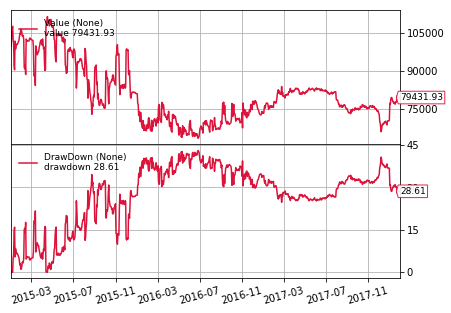

Sharpe Ratio:  0.06905550093161157
SQN:  -0.7968258492624236
Final Portfolio Value: 79431.93


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 12-2
2014-12-31, Close 807.27 1025.04 239.55 577.51 1156.42 884.94 838.09 411.30 755.98 473.86 125.46 490.40 
2014-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 
2015-01-01, Buy 86 Oil & Gas
2015-01-01, Buy 391 Basic Materials
2015-01-30, Close 838.18 1069.09 249.91 565.32 1235.05 887.66 869.16 416.27 789.89 501.31 144.49 489.42 
2015-01-30, Current Positions: 0 0 0 86 0 0 0 0 0 0 391 0 
2015-02-02, Sell 23 Basic Materials
2015-02-27, Close 832.44 1105.92 246.14 558.96 1232.03 894.84 848.32 413.97 803.13 469.93 135.87 481.51 
2015-02-27, Current Positions: 0 0 0 86 0 0 0 0 0 0 368 0 
2015-03-02, Buy 5 Oil & Gas
2015-03-02, Buy 9 Basic Materials
2015-03-31, Close 826.24 1143.95 247.24 558.97 1325.29 903.50 833.98 422.95 806.08 508.59 131.35 502.86 
2015-03-31, Current Positions: 0 0 0 91 0 0 0 0 0 0 377 0 
2015-04-30, Close

2017-10-31, Close 813.81 943.75 300.57 404.16 1230.00 976.41 740.80 242.56 855.47 375.52 103.21 540.75 
2017-10-31, Current Positions: 0 0 0 0 30 0 0 153 0 0 0 0 
2017-11-30, Close 804.73 943.06 317.07 400.63 1191.98 1005.65 758.60 241.44 853.17 359.84 77.87 513.88 
2017-11-30, Current Positions: 0 0 0 0 30 0 0 153 0 0 0 0 
2017-12-01, Sell 153 Technology
2017-12-01, Buy 47 Consumer Services
2017-12-01, OPERATION PROFIT, GROSS -560.42, NET -566.40
2017-12-29, Close 777.92 912.18 289.97 389.93 1229.61 1014.27 749.84 244.91 862.64 364.70 68.74 499.64 
2017-12-29, Current Positions: 0 0 0 0 30 0 47 0 0 0 0 0 
2018-01-01, Sell 47 Consumer Services
2018-01-01, Buy 528 Basic Materials
2018-01-01, OPERATION PROFIT, GROSS -418.77, NET -424.45


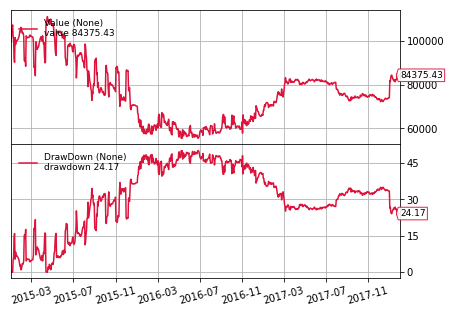

Sharpe Ratio:  0.11538612296598204
SQN:  -0.794974700529961
Final Portfolio Value: 84375.43


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 12-7
2014-12-31, Close 807.27 1025.04 239.55 577.51 1156.42 884.94 838.09 411.30 755.98 473.86 125.46 490.40 
2014-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 
2015-01-01, Buy 207 Maritime
2015-01-01, Buy 391 Basic Materials
2015-01-30, Close 838.18 1069.09 249.91 565.32 1235.05 887.66 869.16 416.27 789.89 501.31 144.49 489.42 
2015-01-30, Current Positions: 0 0 207 0 0 0 0 0 0 0 391 0 
2015-02-02, Sell 12 Basic Materials
2015-02-27, Close 832.44 1105.92 246.14 558.96 1232.03 894.84 848.32 413.97 803.13 469.93 135.87 481.51 
2015-02-27, Current Positions: 0 0 207 0 0 0 0 0 0 0 379 0 
2015-03-02, Sell 207 Maritime
2015-03-02, Buy 111 Utilities
2015-03-02, Buy 8 Basic Materials
2015-03-02, OPERATION PROFIT, GROSS 1169.55, NET 1161.52
2015-03-31, Close 826.24 1143.95 247.24 558.97 1325.29 903.50 833.98 422.95 806.08 508.59 1

2017-07-03, Sell 123 Utilities
2017-07-03, Buy 46 Telecommunications
2017-07-03, Buy 5 Maritime
2017-07-03, OPERATION PROFIT, GROSS 608.85, NET 601.34
2017-07-31, Close 787.92 997.04 273.31 360.70 1356.38 945.42 758.16 237.47 836.94 366.12 95.14 526.94 
2017-07-31, Current Positions: 0 46 197 0 0 0 0 0 0 0 0 0 
2017-08-01, Sell 197 Maritime
2017-08-01, Buy 4 Telecommunications
2017-08-01, Buy 136 Utilities
2017-08-01, OPERATION PROFIT, GROSS 22425.36, NET 22416.58
2017-08-31, Close 814.08 931.59 287.26 346.99 1219.73 935.60 749.71 246.36 839.55 377.23 97.40 517.66 
2017-08-31, Current Positions: 0 50 0 0 0 0 0 0 0 136 0 0 
2017-09-01, Sell 50 Telecommunications
2017-09-01, Sell 136 Utilities
2017-09-01, Buy 40 Healthcare
2017-09-01, Buy 202 Technology
2017-09-01, OPERATION PROFIT, GROSS -2095.46, NET -2103.14
2017-09-01, OPERATION PROFIT, GROSS 875.84, NET 867.79
2017-09-29, Close 798.15 926.62 275.77 355.63 1224.84 928.20 728.36 242.32 829.06 370.01 95.49 501.94 
2017-09-29, Current P

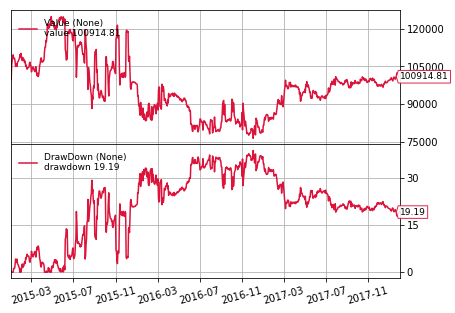

Sharpe Ratio:  0.19619052699511996
SQN:  -0.019145981075634397
Final Portfolio Value: 100914.81


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 6-1
2014-12-31, Close 807.27 1025.04 239.55 577.51 1156.42 884.94 838.09 411.30 755.98 473.86 125.46 490.40 
2014-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 
2015-01-01, Buy 86 Oil & Gas
2015-01-01, Buy 391 Basic Materials
2015-01-30, Close 838.18 1069.09 249.91 565.32 1235.05 887.66 869.16 416.27 789.89 501.31 144.49 489.42 
2015-01-30, Current Positions: 0 0 0 86 0 0 0 0 0 0 391 0 
2015-02-02, Sell 23 Basic Materials
2015-02-27, Close 832.44 1105.92 246.14 558.96 1232.03 894.84 848.32 413.97 803.13 469.93 135.87 481.51 
2015-02-27, Current Positions: 0 0 0 86 0 0 0 0 0 0 368 0 
2015-03-02, Buy 5 Oil & Gas
2015-03-02, Buy 9 Basic Materials
2015-03-31, Close 826.24 1143.95 247.24 558.97 1325.29 903.50 833.98 422.95 806.08 508.59 131.35 502.86 
2015-03-31, Current Positions: 0 0 0 91 0 0 0 0 0 0 377 0 
2015-04-30, Clo

2017-08-01, Sell 79 Consumer Goods
2017-08-01, Buy 1 Healthcare
2017-08-01, Buy 405 Basic Materials
2017-08-01, OPERATION PROFIT, GROSS 1214.23, NET 1207.66
2017-08-31, Close 814.08 931.59 287.26 346.99 1219.73 935.60 749.71 246.36 839.55 377.23 97.40 517.66 
2017-08-31, Current Positions: 0 0 0 0 30 0 0 0 0 0 405 0 
2017-09-01, Buy 2 Healthcare
2017-09-01, Sell 1 Basic Materials
2017-09-29, Close 798.15 926.62 275.77 355.63 1224.84 928.20 728.36 242.32 829.06 370.01 95.49 501.94 
2017-09-29, Current Positions: 0 0 0 0 32 0 0 0 0 0 404 0 
2017-10-31, Close 813.81 943.75 300.57 404.16 1230.00 976.41 740.80 242.56 855.47 375.52 103.21 540.75 
2017-10-31, Current Positions: 0 0 0 0 32 0 0 0 0 0 404 0 
2017-11-01, Sell 404 Basic Materials
2017-11-01, Buy 54 Consumer Services
2017-11-01, OPERATION PROFIT, GROSS 3550.41, NET 3543.96
2017-11-30, Close 804.73 943.06 317.07 400.63 1191.98 1005.65 758.60 241.44 853.17 359.84 77.87 513.88 
2017-11-30, Current Positions: 0 0 0 0 32 0 54 0 0 0 0 0 

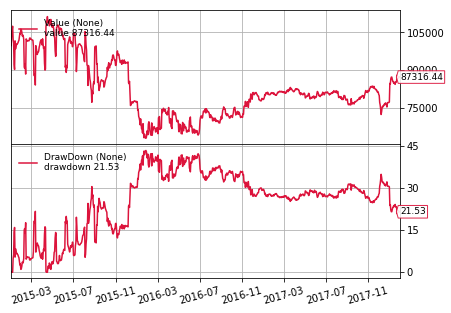

Sharpe Ratio:  0.08714374944471824
SQN:  -0.40180894254916555
Final Portfolio Value: 87316.44


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 6-2
2014-12-31, Close 807.27 1025.04 239.55 577.51 1156.42 884.94 838.09 411.30 755.98 473.86 125.46 490.40 
2014-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 
2015-01-01, Buy 42 Healthcare
2015-01-01, Buy 391 Basic Materials
2015-01-30, Close 838.18 1069.09 249.91 565.32 1235.05 887.66 869.16 416.27 789.89 501.31 144.49 489.42 
2015-01-30, Current Positions: 0 0 0 0 42 0 0 0 0 0 391 0 
2015-02-02, Sell 42 Healthcare
2015-02-02, Sell 7 Basic Materials
2015-02-02, OPERATION PROFIT, GROSS 3709.02, NET 3701.01
2015-02-27, Close 832.44 1105.92 246.14 558.96 1232.03 894.84 848.32 413.97 803.13 469.93 135.87 481.51 
2015-02-27, Current Positions: 0 0 0 0 0 0 0 0 0 0 384 0 
2015-03-02, Buy 93 Oil & Gas
2015-03-02, Buy 11 Basic Materials
2015-03-31, Close 826.24 1143.95 247.24 558.97 1325.29 903.50 833.98 422.95 806.08 508.59 13

In [ ]:
full_returns_dict = {}
full_values_dict = OrderedDict()

if __name__ == '__main__':
    
    for i in full_raw_dict.keys():
        
        # Create a cerebro entity
        cerebro = bt.Cerebro(stdstats=False)
        
        # Add the datafeeds into cerebro
        for key in full_raw_dict[i].keys():
            data = CustomDataLoader(dataname=full_raw_dict[i][key])
            data.plotinfo.plot = False
            cerebro.adddata(data, name=key)
    
        # Add a strategy and define our holding period
        cerebro.addstrategy(NewMomentumStrategy, period=1)
    
        # Set our desired cash start
        cerebro.broker.setcash(100000.0)
    
        # Set the commission
        cerebro.broker.setcommission(commission=0.00008, interest=0.0)
        cerebro.broker.set_checksubmit(False)

        # Add analyzers to cerebro
        #cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
        cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe', riskfreerate=0.0, timeframe=bt.TimeFrame.Days)
        cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
        # Add observers to cerebro
        cerebro.addobserver(bt.observers.Value)
        cerebro.addobserver(bt.observers.DrawDown)

        # Print out the starting conditions
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('Currently testing strategy ' + str(i))
    
        # Run over everything
        strategies = cerebro.run()
        firstStrat = strategies[0]
    
        # Plot everything
        fig = cerebro.plot()
    
        # Print the analyzers
        #print('Trade Analysis' + firstStrat.analyzers.ta.get_analysis())
        print('Sharpe Ratio: ', firstStrat.analyzers.mysharpe.get_analysis()['sharperatio'])
        print('SQN: ', firstStrat.analyzers.sqn.get_analysis()['sqn'])
    
        # Get the pyfolio data and store it into a dictionary
        pyfoliozer = firstStrat.analyzers.pyfolio
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        full_returns_dict[str(i)] = returns
        full_values_dict[str(i)] = cerebro.broker.getvalue()
    
        # Print out the final result
        print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('\n')


In [55]:
full_returns_dict_1M = full_returns_dict.copy()

In [58]:
full_returns_dict_3M = full_returns_dict.copy()

In [60]:
full_returns_dict_6M = full_returns_dict.copy()

## General Test Parameters:
- Backtesting period: 1/1/2011 to 1/31/2018
- Number of reits included in our portfolio: Long the top 10% and short the bottom 10%
- Comission cost: 0.08%
- Short interest rate: 6.00%
- Risk free rate: 0.00%

To benchmark our performance, we will be comparing it with the STI index.

In [48]:
# Create a copy of STI returns
STI = index_backtest_data['STI'].copy()

# Calculate the returns
sti_rets = STI['Close'].pct_change().fillna(0)
sti_rets.index = sti_rets.index.tz_localize('utc')

### Test 1:
- Criteria: MOM 12-2 cumulative returns
- Holding period: 1/3/6 months

#### MOM 12-2 with 1 month holding period

Backtest months: 38


Backtest
Annual return          30.0%
Cumulative returns    131.0%
Annual volatility      70.8%
Sharpe ratio            0.74
Calmar ratio            0.75
Stability               0.73
Max drawdown          -40.1%
Omega ratio             1.24
Sortino ratio           1.06
Skew                   -0.36
Kurtosis               24.94
Tail ratio              1.26
Daily value at risk    -8.7%
Alpha                   0.54
Beta                   -0.39

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  40.08 2015-10-12  2015-11-02    2015-12-14   
1                                  34.88 2015-08-12  2015-10-02    2015-10-12   
2                                  26.18 2016-11-02  2017-06-01           NaT   
3                                  22.99 2015-03-20  2015-04-28    2015-08-10   
4                                  21.85 2016-09-16  2016-10-03    2016-11-02   

Worst drawdown periods Duration  
0                            46  
1                            44  
2                           NaN  
3                           102  
4                            34

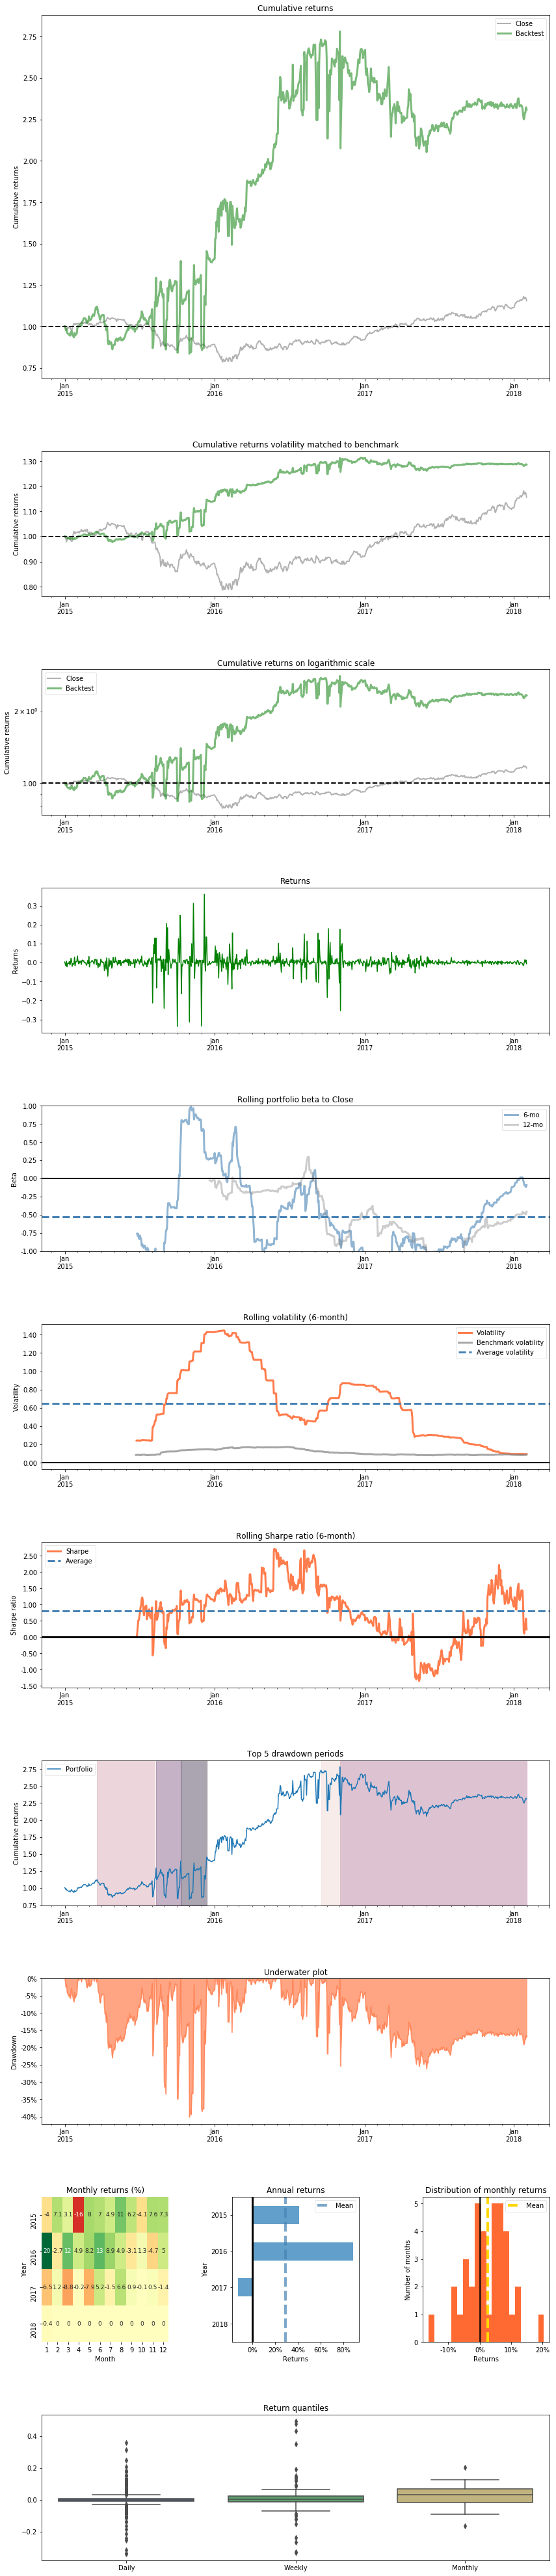

In [56]:
M12_7_1_returns = full_returns_dict_1M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_1_returns, benchmark_rets=sti_rets)

#### MOM 12-2 with 3 months holding period

Backtest months: 88


Backtest
Annual return         -10.5%
Cumulative returns    -55.8%
Annual volatility      16.0%
Sharpe ratio           -0.61
Calmar ratio           -0.16
Stability               0.76
Max drawdown          -66.4%
Omega ratio             0.90
Sortino ratio          -0.87
Skew                    0.26
Kurtosis                2.46
Tail ratio              1.05
Daily value at risk    -2.1%
Alpha                  -0.11
Beta                    0.39

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  66.44 2012-02-22  2018-01-19           NaT   
1                                  10.88 2011-11-14  2011-12-30    2012-01-25   
2                                   8.35 2011-07-20  2011-08-10    2011-10-10   
3                                   7.12 2011-01-28  2011-04-12    2011-07-20   
4                                   5.78 2011-10-12  2011-10-20    2011-10-27   

Worst drawdown periods Duration  
0                           NaN  
1                            53  
2                            59  
3                           124  
4                            12

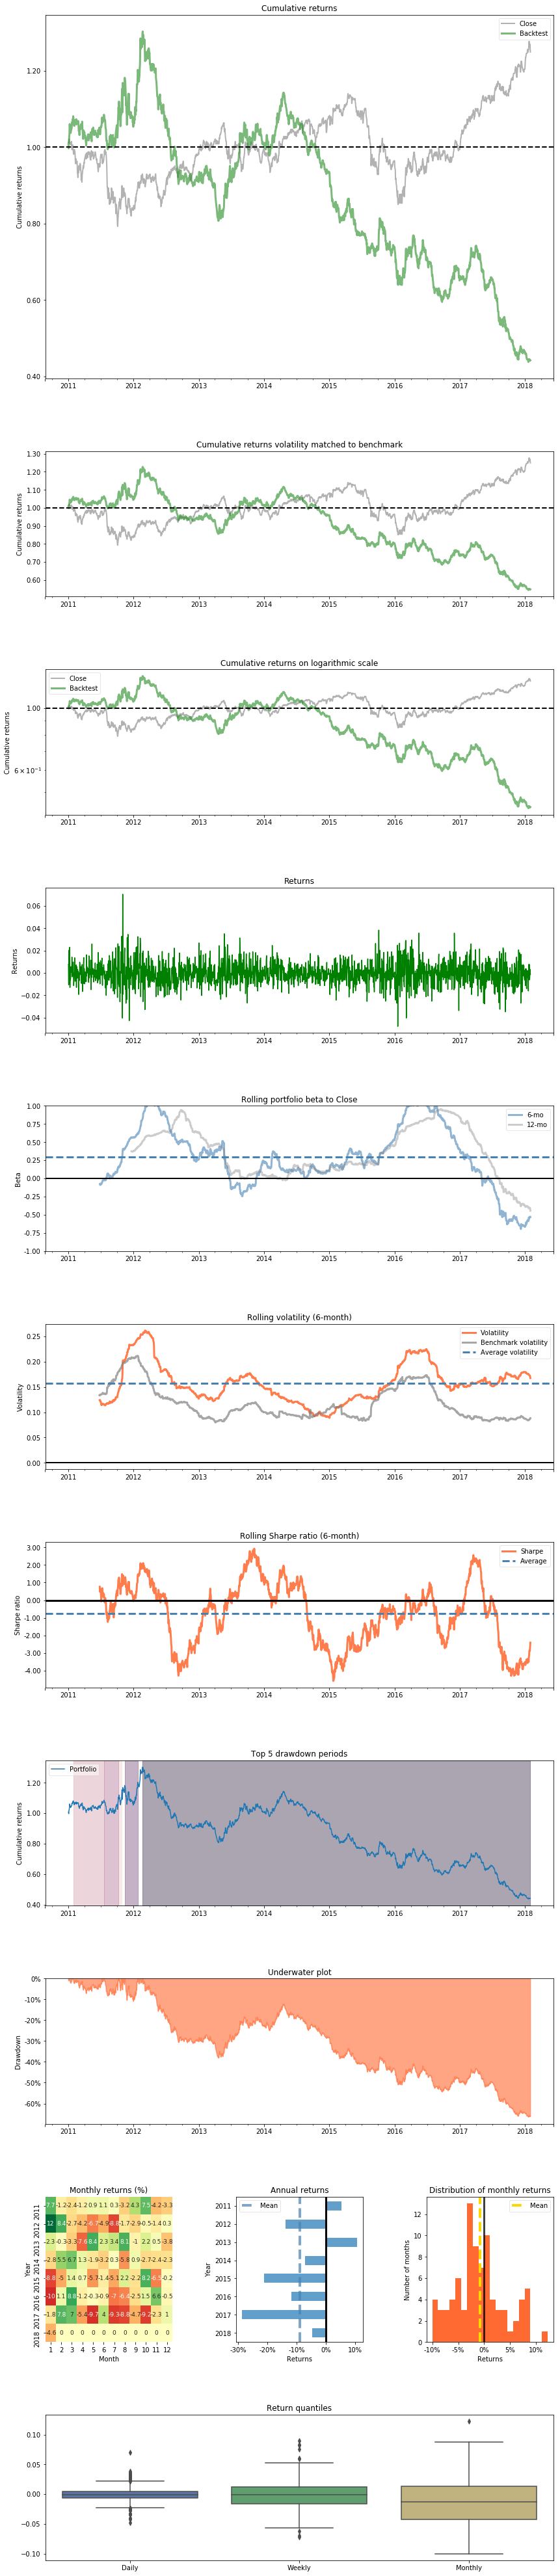

In [62]:
M12_2_3_returns = full_returns_dict_3M['MOM 12-2']
create_custom_tear_sheet(returns=M12_2_3_returns, benchmark_rets=sti_rets)

#### MOM 12-2 with 6 months holding period

Backtest months: 88


Backtest
Annual return         -17.3%
Cumulative returns    -75.2%
Annual volatility      15.7%
Sharpe ratio           -1.13
Calmar ratio           -0.22
Stability               0.91
Max drawdown          -77.8%
Omega ratio             0.83
Sortino ratio          -1.52
Skew                   -0.06
Kurtosis                1.69
Tail ratio              1.03
Daily value at risk    -2.1%
Alpha                  -0.19
Beta                    0.27

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  77.76 2012-02-22  2017-11-22           NaT   
1                                  17.30 2011-01-28  2012-01-02    2012-02-09   
2                                   2.20 2011-01-10  2011-01-14    2011-01-21   
3                                   2.14 2012-02-09  2012-02-10    2012-02-21   
4                                   1.06 2011-01-03  2011-01-04    2011-01-05   

Worst drawdown periods Duration  
0                           NaN  
1                           270  
2                            10  
3                             9  
4                             3

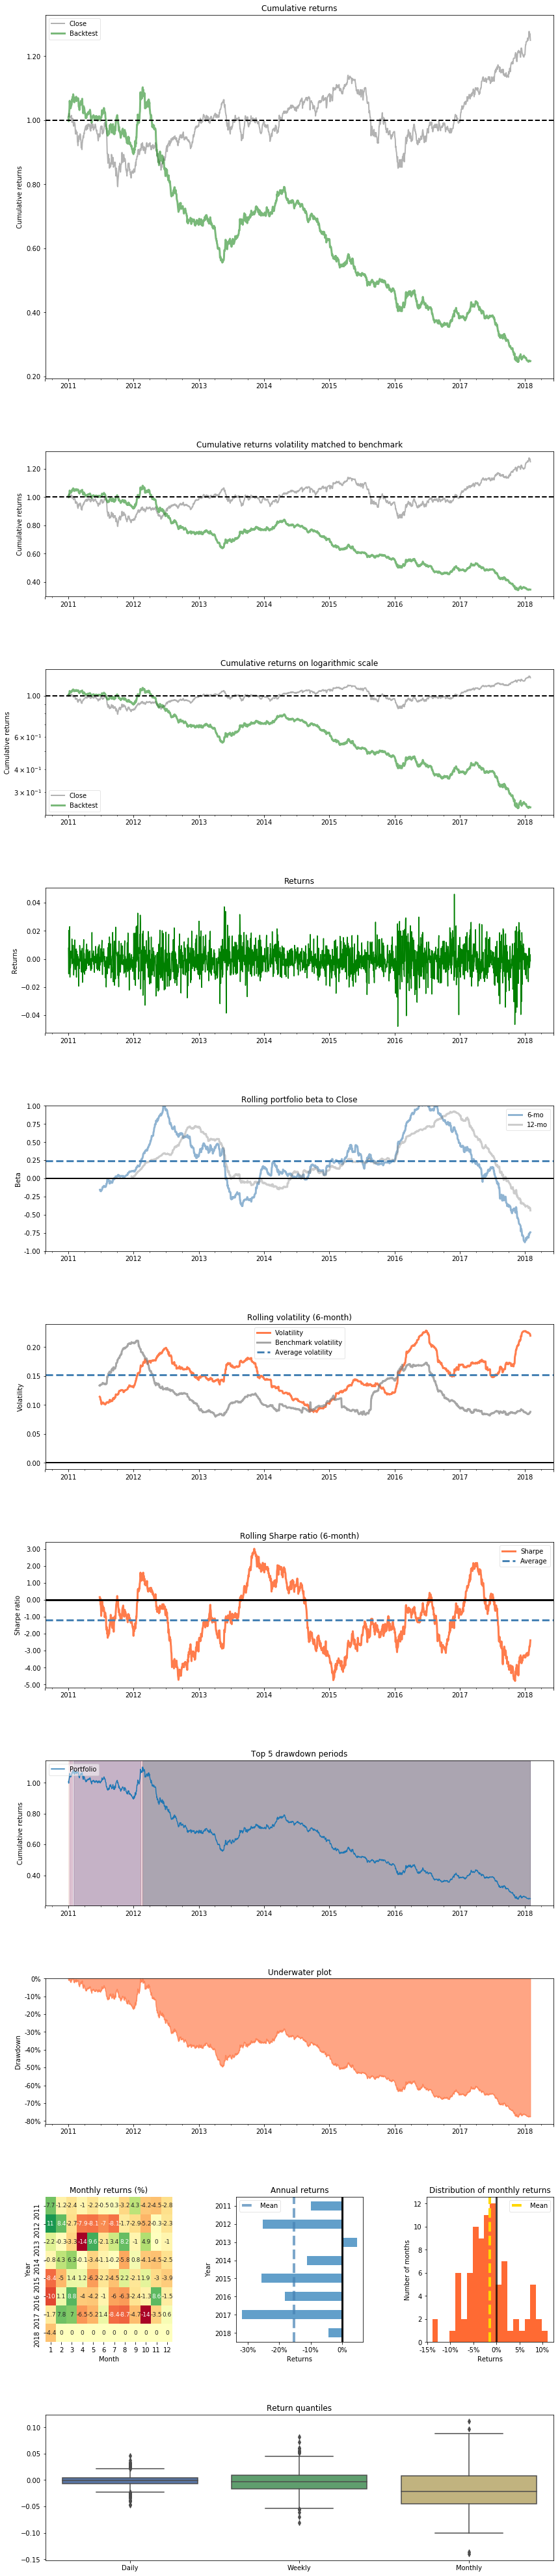

In [63]:
M12_2_6_returns = full_returns_dict_6M['MOM 12-2']
create_custom_tear_sheet(returns=M12_2_6_returns, benchmark_rets=sti_rets)

### Test 2:
- Criteria: MOM 12-7 cumulative returns
- Holding period: 1/3/6 months

#### MOM 12-7 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -5.6%
Cumulative returns    -34.6%
Annual volatility      14.2%
Sharpe ratio           -0.34
Calmar ratio           -0.14
Stability               0.70
Max drawdown          -41.3%
Omega ratio             0.94
Sortino ratio          -0.47
Skew                    0.10
Kurtosis                1.73
Tail ratio              1.00
Daily value at risk    -1.8%
Alpha                  -0.06
Beta                    0.20

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  41.31 2011-10-04  2018-01-15           NaT   
1                                  11.80 2011-02-11  2011-05-12    2011-10-03   
2                                   1.79 2011-01-26  2011-02-07    2011-02-10   
3                                   1.52 2011-01-12  2011-01-14    2011-01-24   
4                                   0.49 2011-01-10  2011-01-11    2011-01-12   

Worst drawdown periods Duration  
0                           NaN  
1                           167  
2                            12  
3                             9  
4                             3

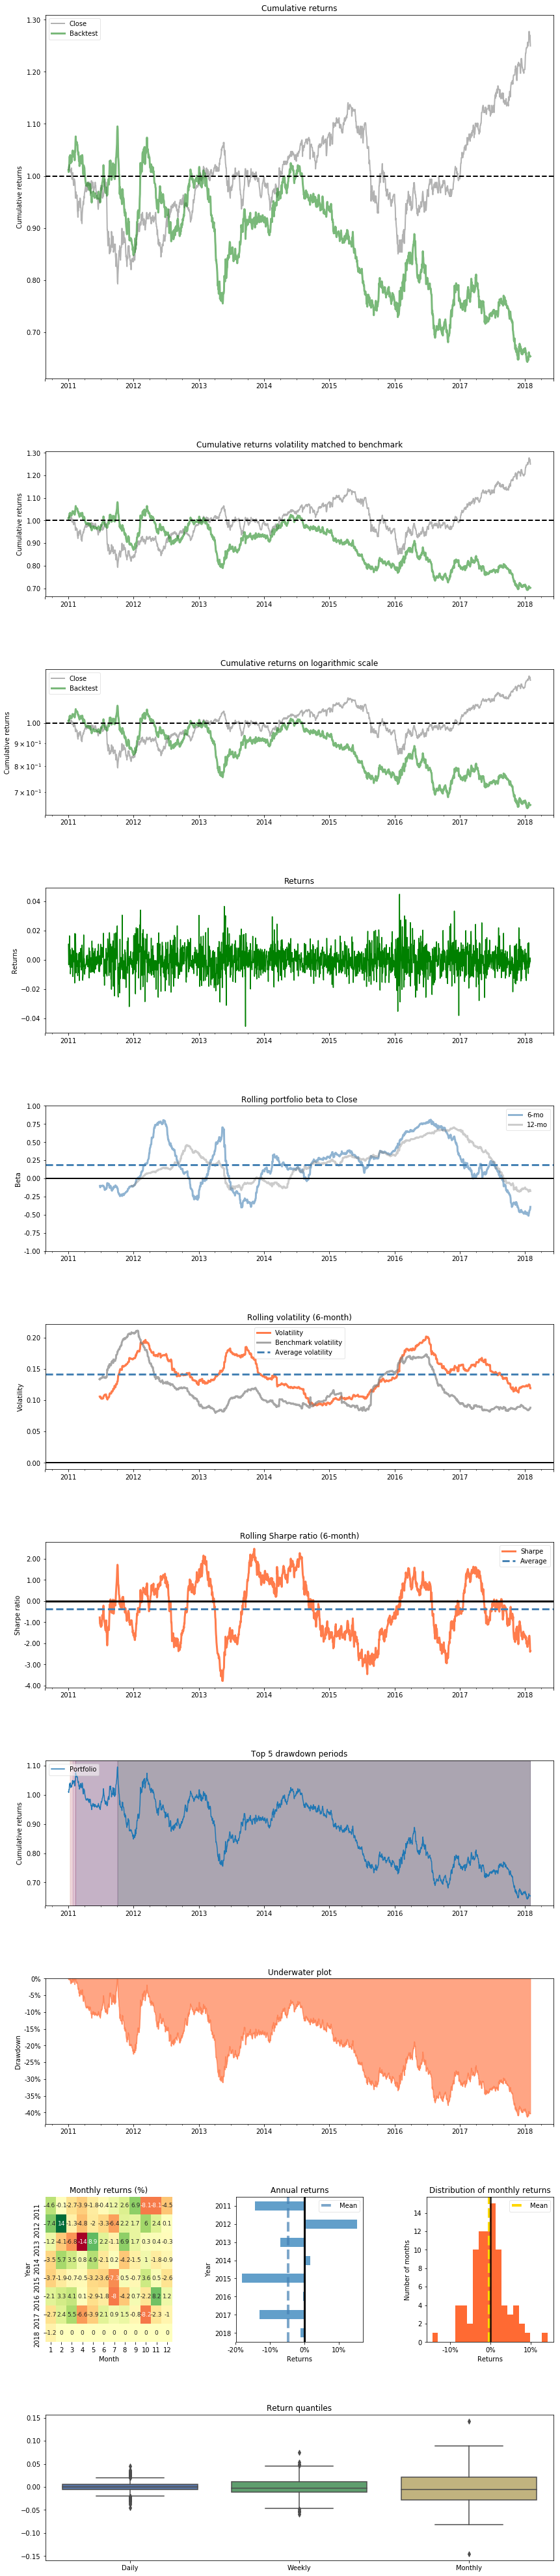

In [64]:
M12_7_1_returns = full_returns_dict_1M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_1_returns, benchmark_rets=sti_rets)

#### MOM 12-7 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -7.3%
Cumulative returns    -42.7%
Annual volatility      15.0%
Sharpe ratio           -0.43
Calmar ratio           -0.14
Stability               0.78
Max drawdown          -53.4%
Omega ratio             0.93
Sortino ratio          -0.61
Skew                    0.15
Kurtosis                1.47
Tail ratio              0.94
Daily value at risk    -1.9%
Alpha                  -0.07
Beta                    0.14

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  53.44 2011-10-04  2017-11-24           NaT   
1                                  10.71 2011-02-11  2011-05-12    2011-08-11   
2                                   4.69 2011-08-26  2011-08-31    2011-09-28   
3                                   1.55 2011-08-15  2011-08-17    2011-08-19   
4                                   1.52 2011-01-12  2011-01-14    2011-01-24   

Worst drawdown periods Duration  
0                           NaN  
1                           130  
2                            24  
3                             5  
4                             9

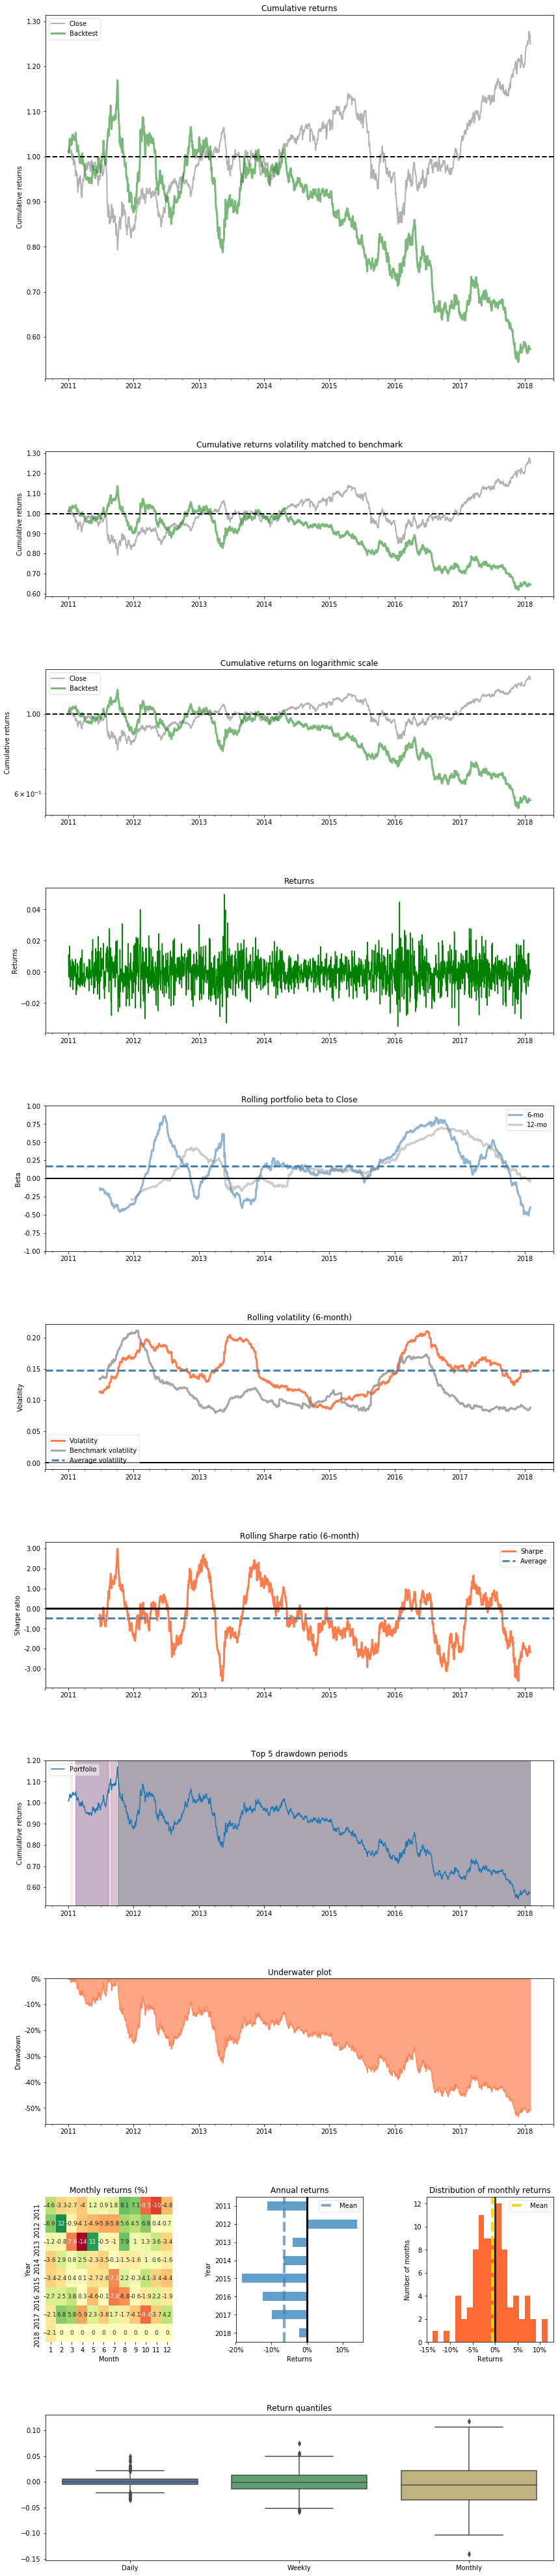

In [65]:
M12_7_3_returns = full_returns_dict_3M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_3_returns, benchmark_rets=sti_rets)

#### MOM 12-7 with 6 months holding period

Backtest months: 88


Backtest
Annual return          -5.3%
Cumulative returns    -32.8%
Annual volatility      14.6%
Sharpe ratio           -0.30
Calmar ratio           -0.12
Stability               0.58
Max drawdown          -45.7%
Omega ratio             0.95
Sortino ratio          -0.43
Skew                    0.23
Kurtosis                2.08
Tail ratio              0.99
Daily value at risk    -1.9%
Alpha                  -0.05
Beta                    0.09

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  45.69 2012-02-22  2018-01-15           NaT   
1                                  13.65 2011-10-04  2012-01-02    2012-02-08   
2                                  11.87 2011-02-11  2011-06-15    2011-08-24   
3                                   4.72 2011-08-26  2011-08-31    2011-09-28   
4                                   2.43 2012-02-09  2012-02-16    2012-02-20   

Worst drawdown periods Duration  
0                           NaN  
1                            92  
2                           139  
3                            24  
4                             8

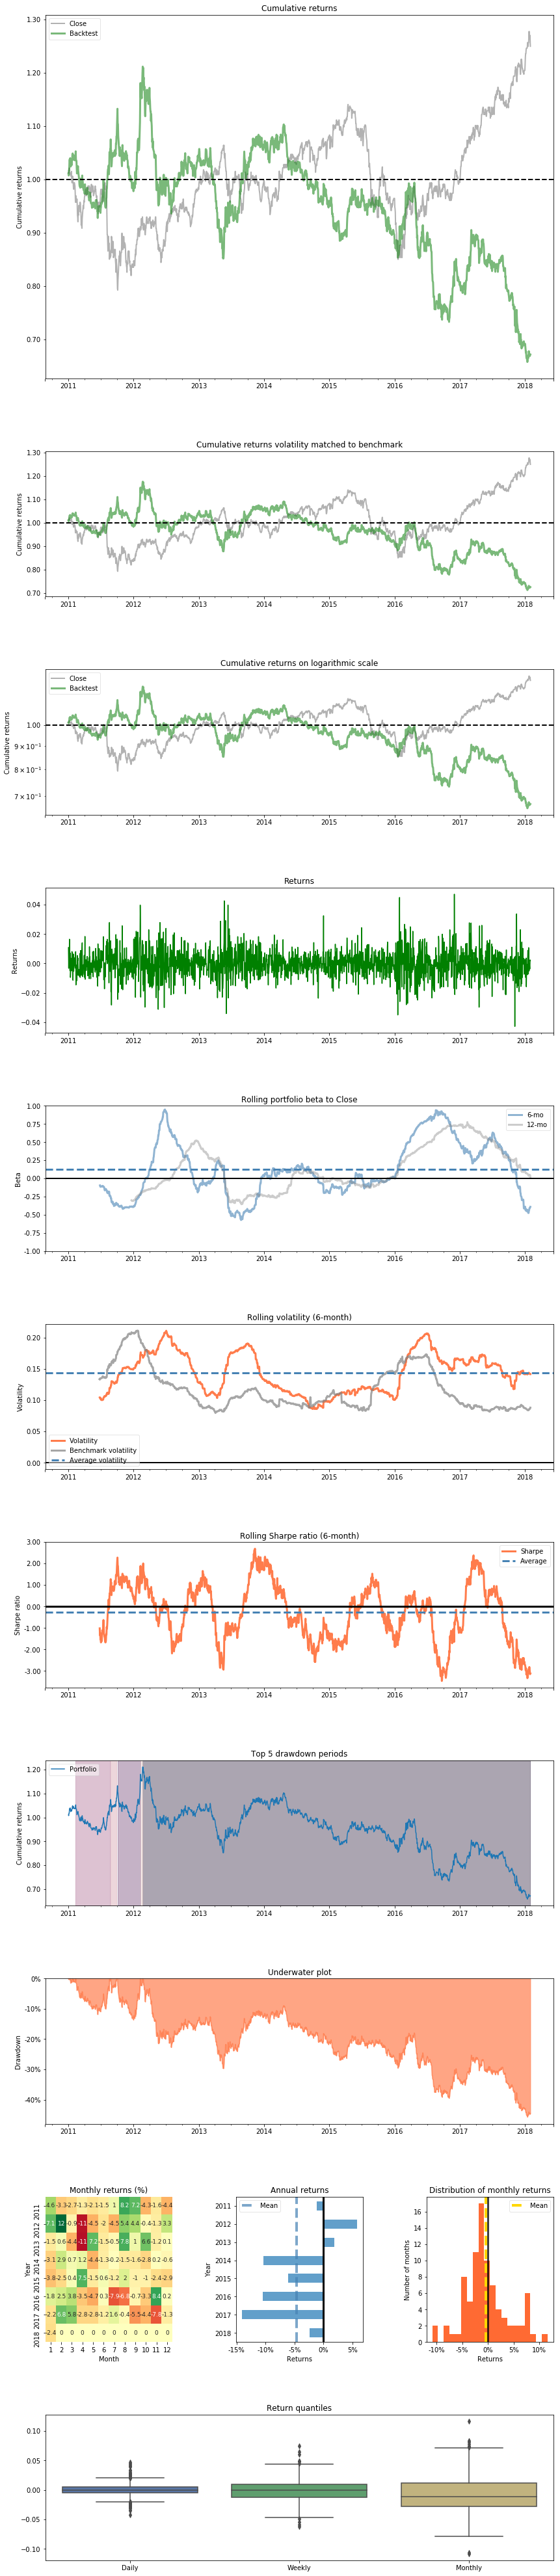

In [66]:
M12_7_6_returns = full_returns_dict_6M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_6_returns, benchmark_rets=sti_rets)

### Test 3:
- Criteria: MOM 6-2 cumulative returns
- Holding period: 1/3/6 months

#### MOM 6-2 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -6.6%
Cumulative returns    -39.3%
Annual volatility      14.4%
Sharpe ratio           -0.40
Calmar ratio           -0.14
Stability               0.73
Max drawdown          -48.1%
Omega ratio             0.93
Sortino ratio          -0.57
Skew                    0.20
Kurtosis                1.58
Tail ratio              1.03
Daily value at risk    -1.8%
Alpha                  -0.07
Beta                    0.20

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  48.07 2012-05-09  2018-01-29           NaT   
1                                  18.81 2011-02-24  2011-09-13    2012-02-09   
2                                   3.88 2012-03-07  2012-03-15    2012-05-03   
3                                   3.07 2011-01-31  2011-02-04    2011-02-21   
4                                   2.15 2012-02-15  2012-02-17    2012-02-27   

Worst drawdown periods Duration  
0                           NaN  
1                           251  
2                            42  
3                            16  
4                             9

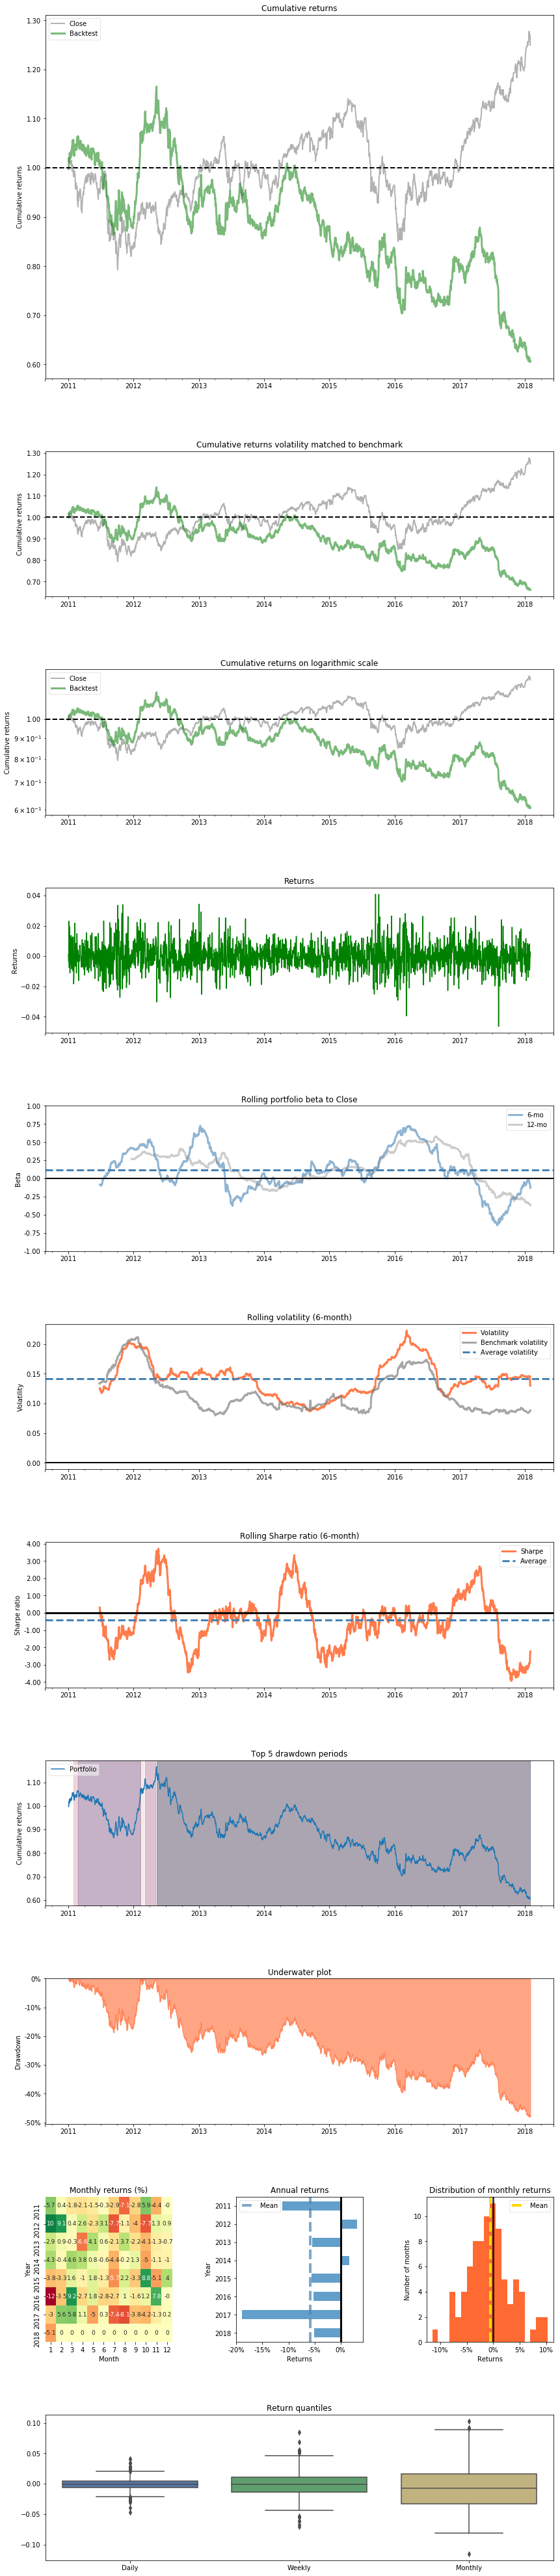

In [67]:
M6_2_1_returns = full_returns_dict_1M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_1_returns, benchmark_rets=sti_rets)

#### MOM 6-2 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -8.1%
Cumulative returns    -46.1%
Annual volatility      14.8%
Sharpe ratio           -0.49
Calmar ratio           -0.15
Stability               0.79
Max drawdown          -53.5%
Omega ratio             0.92
Sortino ratio          -0.70
Skew                    0.45
Kurtosis                3.57
Tail ratio              1.00
Daily value at risk    -1.9%
Alpha                  -0.08
Beta                    0.26

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  53.53 2012-05-18  2018-01-29           NaT   
1                                  16.50 2011-02-25  2011-10-04    2012-02-09   
2                                   3.59 2012-03-02  2012-03-22    2012-04-09   
3                                   2.75 2011-01-31  2011-02-11    2011-02-24   
4                                   1.63 2012-04-11  2012-04-19    2012-04-24   

Worst drawdown periods Duration  
0                           NaN  
1                           250  
2                            27  
3                            19  
4                            10

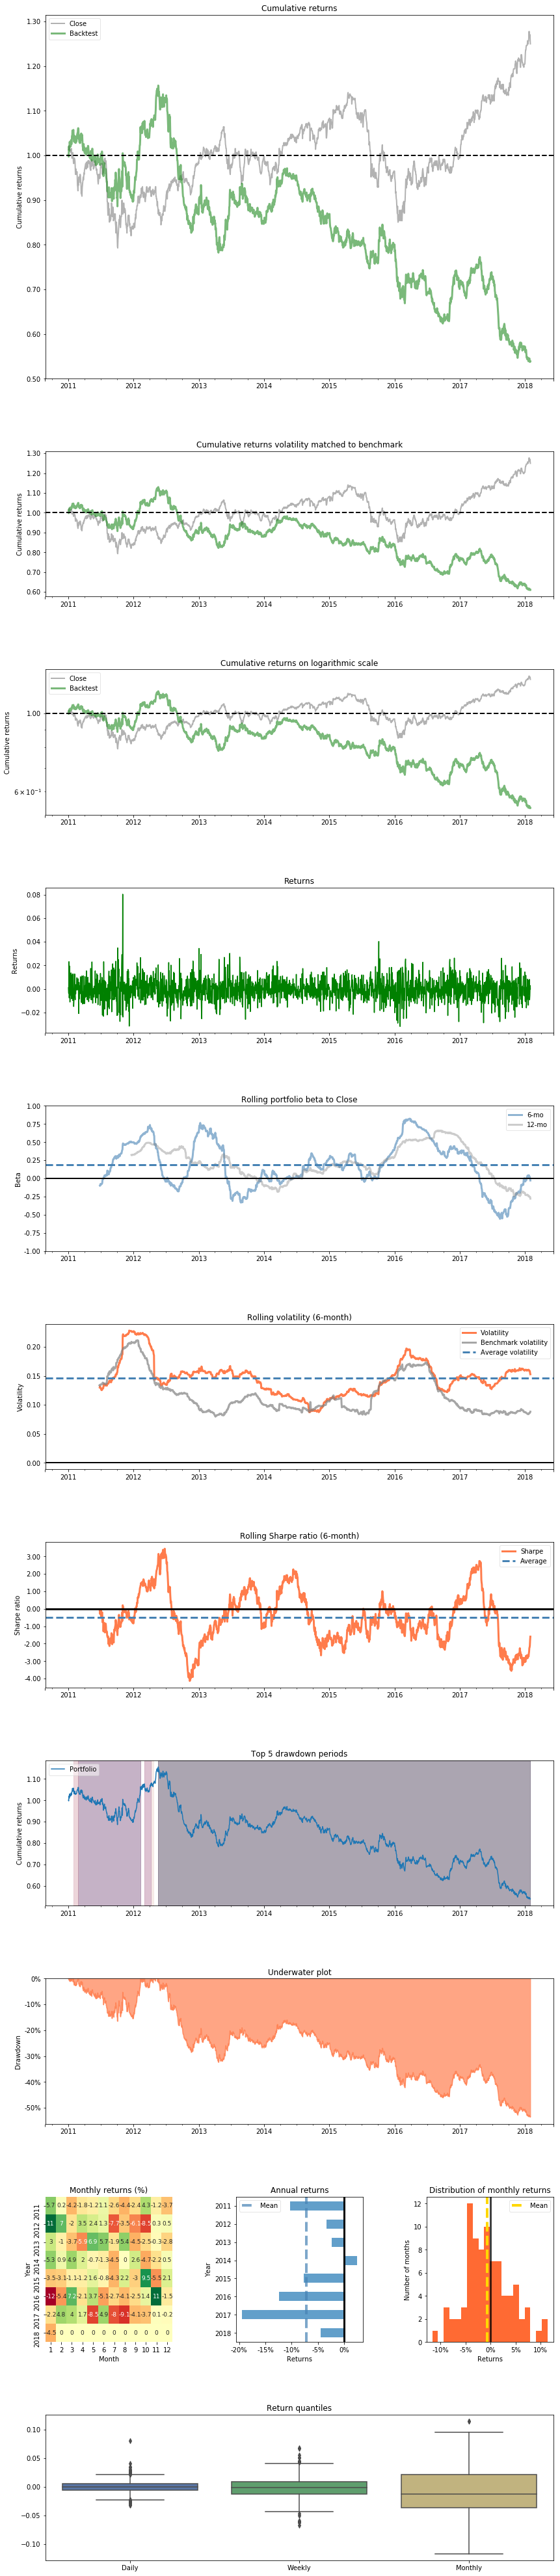

In [68]:
M6_2_3_returns = full_returns_dict_3M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_3_returns, benchmark_rets=sti_rets)

#### MOM 6-2 with 6 months holding period

Backtest months: 88


Backtest
Annual return         -16.0%
Cumulative returns    -72.2%
Annual volatility      14.5%
Sharpe ratio           -1.13
Calmar ratio           -0.22
Stability               0.94
Max drawdown          -73.9%
Omega ratio             0.83
Sortino ratio          -1.52
Skew                   -0.03
Kurtosis                1.15
Tail ratio              0.93
Daily value at risk    -1.9%
Alpha                  -0.17
Beta                    0.23

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  73.89 2011-02-25  2018-01-29           NaT   
1                                   2.75 2011-01-31  2011-02-11    2011-02-24   
2                                   1.27 2011-01-25  2011-01-27    2011-01-31   
3                                   1.11 2011-01-10  2011-01-11    2011-01-17   
4                                   0.93 2011-01-05  2011-01-07    2011-01-10   

Worst drawdown periods Duration  
0                           NaN  
1                            19  
2                             5  
3                             6  
4                             4

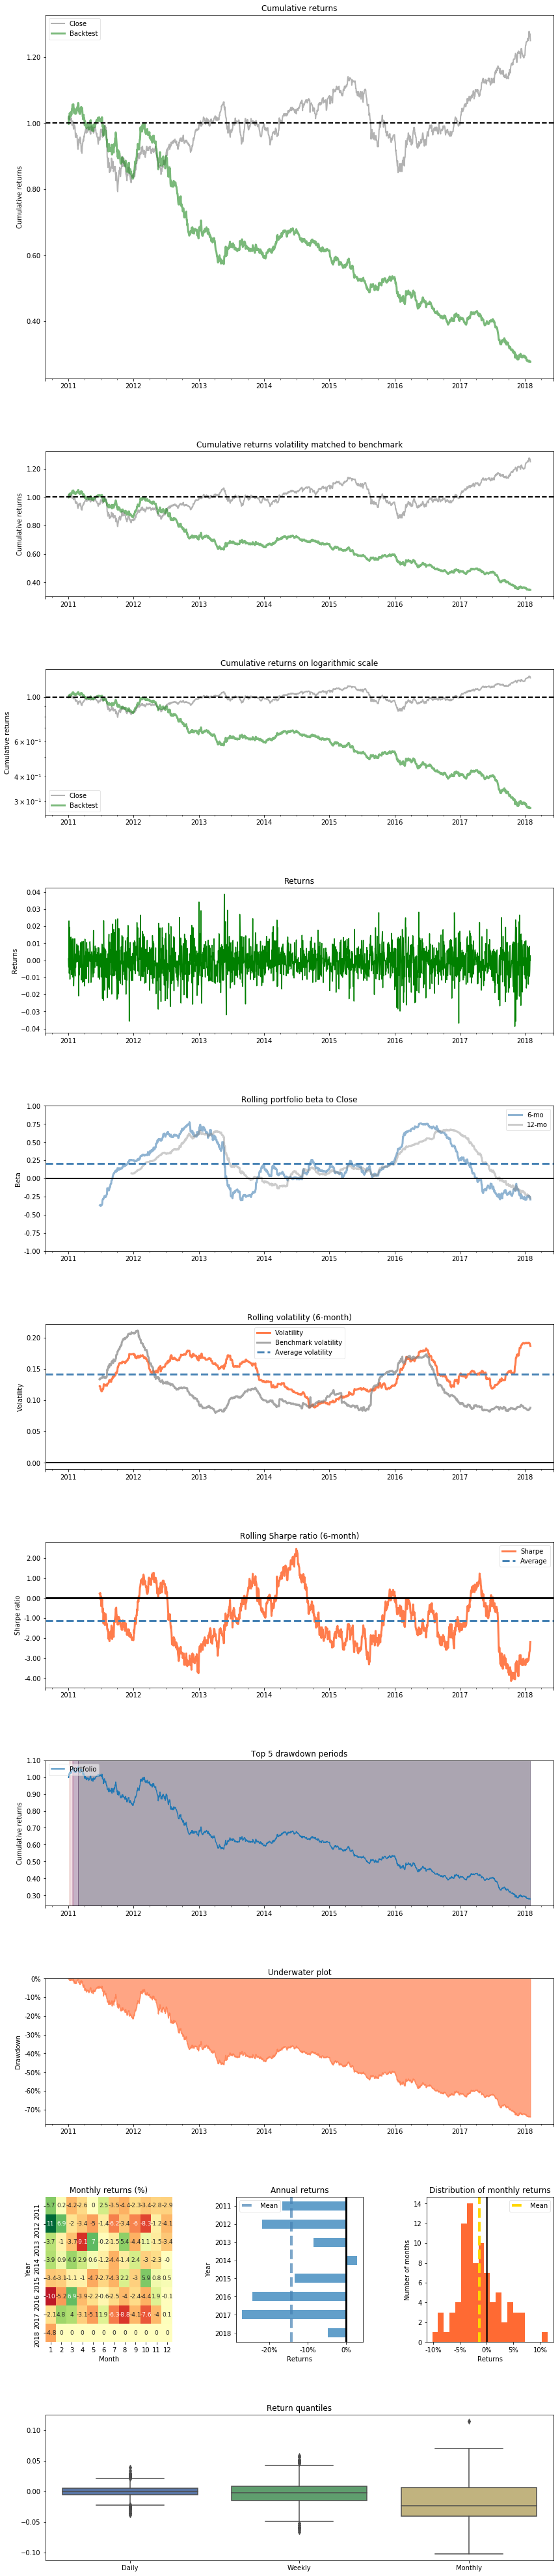

In [69]:
M6_2_6_returns = full_returns_dict_6M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_6_returns, benchmark_rets=sti_rets)

### Test 4:
- Criteria: MOM 2-1 cumulative returns
- Holding period: 1/3/6 months

#### MOM 2-1 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -2.6%
Cumulative returns    -17.6%
Annual volatility      14.3%
Sharpe ratio           -0.11
Calmar ratio           -0.09
Stability               0.54
Max drawdown          -29.2%
Omega ratio             0.98
Sortino ratio          -0.16
Skew                    0.19
Kurtosis                1.59
Tail ratio              1.00
Daily value at risk    -1.8%
Alpha                  -0.02
Beta                    0.22

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  29.16 2011-06-01  2016-02-11           NaT   
1                                   4.93 2011-01-05  2011-02-11    2011-03-07   
2                                   4.36 2011-04-20  2011-05-02    2011-05-23   
3                                   3.86 2011-03-08  2011-03-18    2011-04-06   
4                                   1.03 2011-04-11  2011-04-12    2011-04-14   

Worst drawdown periods Duration  
0                           NaN  
1                            44  
2                            24  
3                            22  
4                             4

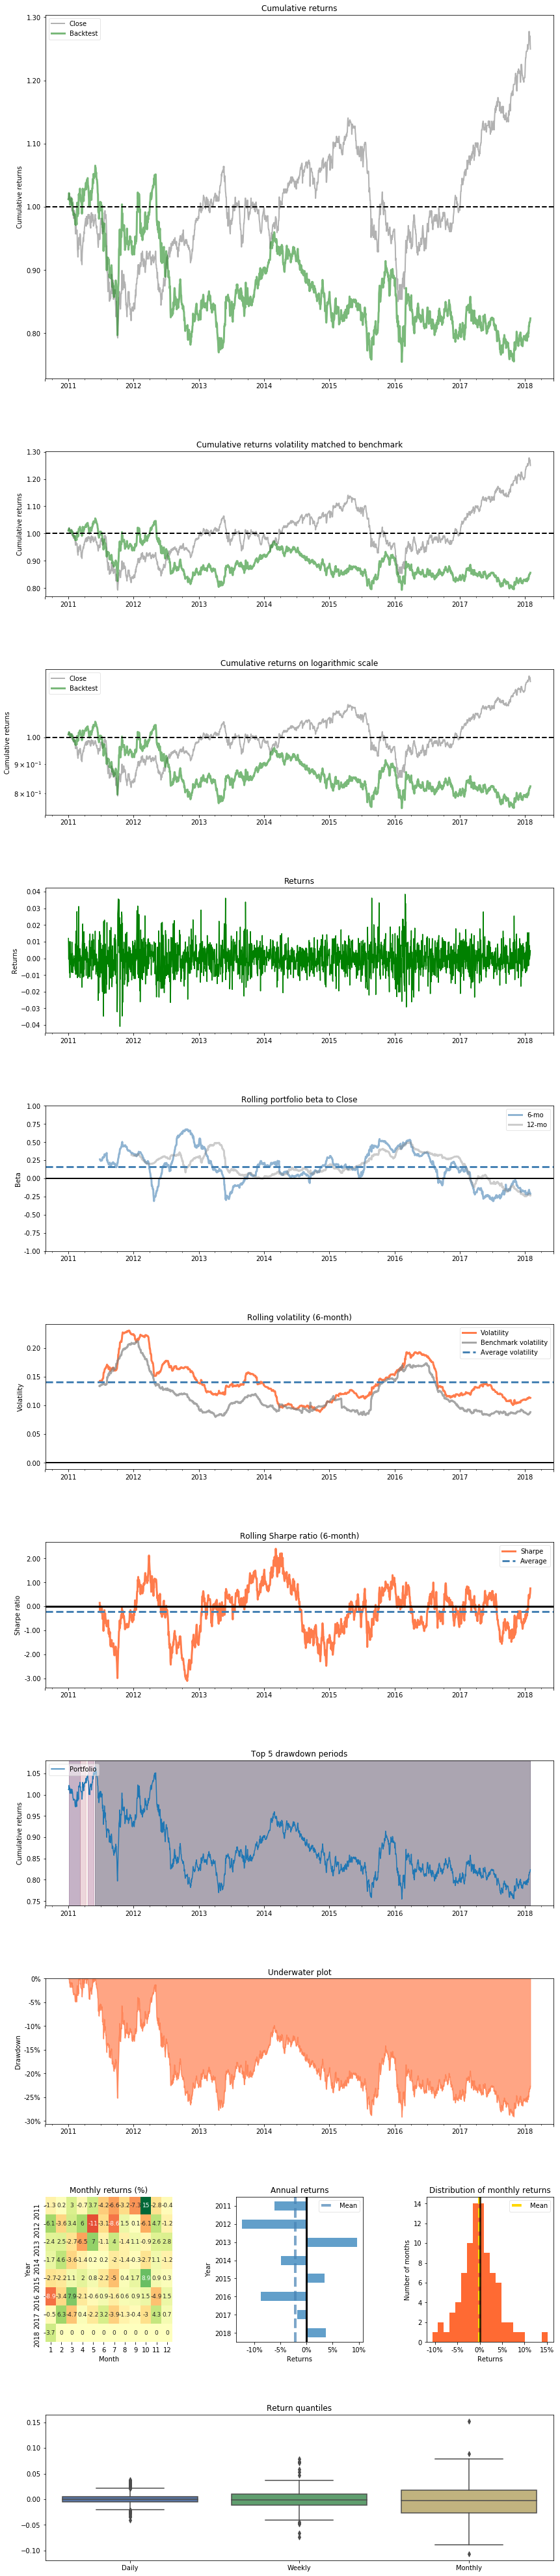

In [70]:
M2_1_1_returns = full_returns_dict_1M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_1_returns, benchmark_rets=sti_rets)

#### MOM 2-1 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -6.5%
Cumulative returns    -39.1%
Annual volatility      14.1%
Sharpe ratio           -0.41
Calmar ratio           -0.14
Stability               0.73
Max drawdown          -46.8%
Omega ratio             0.93
Sortino ratio          -0.58
Skew                    0.09
Kurtosis                2.06
Tail ratio              1.01
Daily value at risk    -1.8%
Alpha                  -0.06
Beta                    0.17

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  46.79 2012-05-18  2018-01-12           NaT   
1                                  29.95 2011-02-21  2011-10-04    2012-04-27   
2                                   4.24 2011-01-05  2011-02-10    2011-02-21   
3                                   0.77 2012-05-14  2012-05-15    2012-05-16   
4                                   0.35 2012-05-09  2012-05-11    2012-05-14   

Worst drawdown periods Duration  
0                           NaN  
1                           310  
2                            34  
3                             3  
4                             4

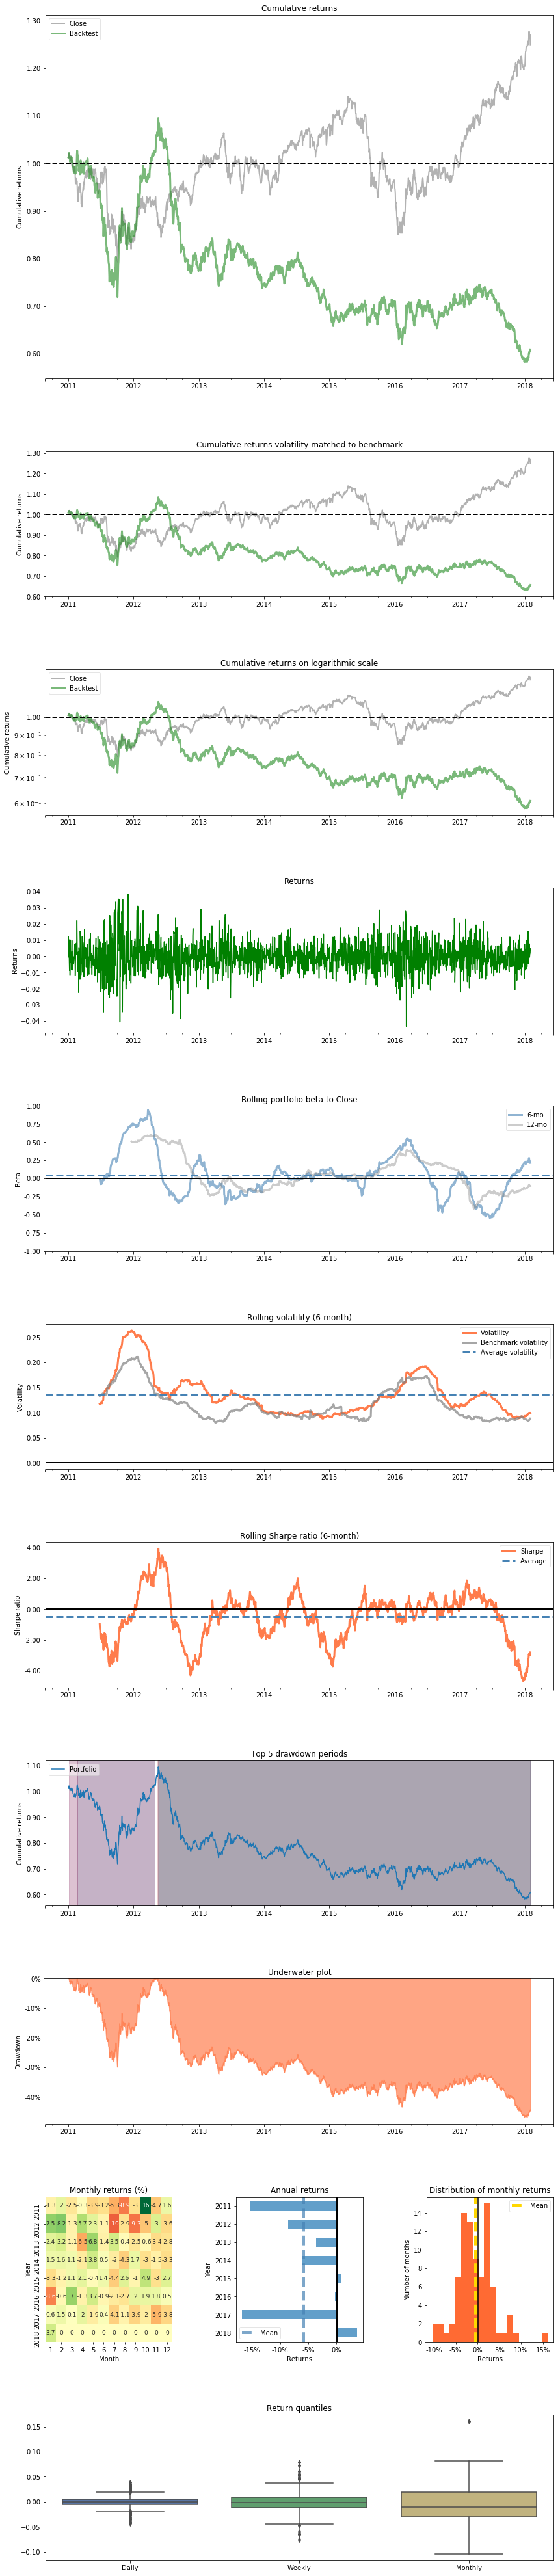

In [71]:
M2_1_3_returns = full_returns_dict_3M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_3_returns, benchmark_rets=sti_rets)

#### MOM 2-1 with 6 months holding period

Backtest months: 88


Backtest
Annual return          -9.6%
Cumulative returns    -52.2%
Annual volatility      13.4%
Sharpe ratio           -0.69
Calmar ratio           -0.17
Stability               0.88
Max drawdown          -57.9%
Omega ratio             0.89
Sortino ratio          -0.97
Skew                    0.33
Kurtosis                2.51
Tail ratio              1.03
Daily value at risk    -1.7%
Alpha                  -0.10
Beta                    0.12

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  57.90 2012-02-24  2016-02-11           NaT   
1                                  13.41 2011-02-21  2011-09-02    2012-02-08   
2                                   4.24 2011-01-05  2011-02-10    2011-02-21   
3                                   1.30 2012-02-09  2012-02-17    2012-02-21   
4                                   1.27 2012-02-22  2012-02-23    2012-02-24   

Worst drawdown periods Duration  
0                           NaN  
1                           253  
2                            34  
3                             9  
4                             3

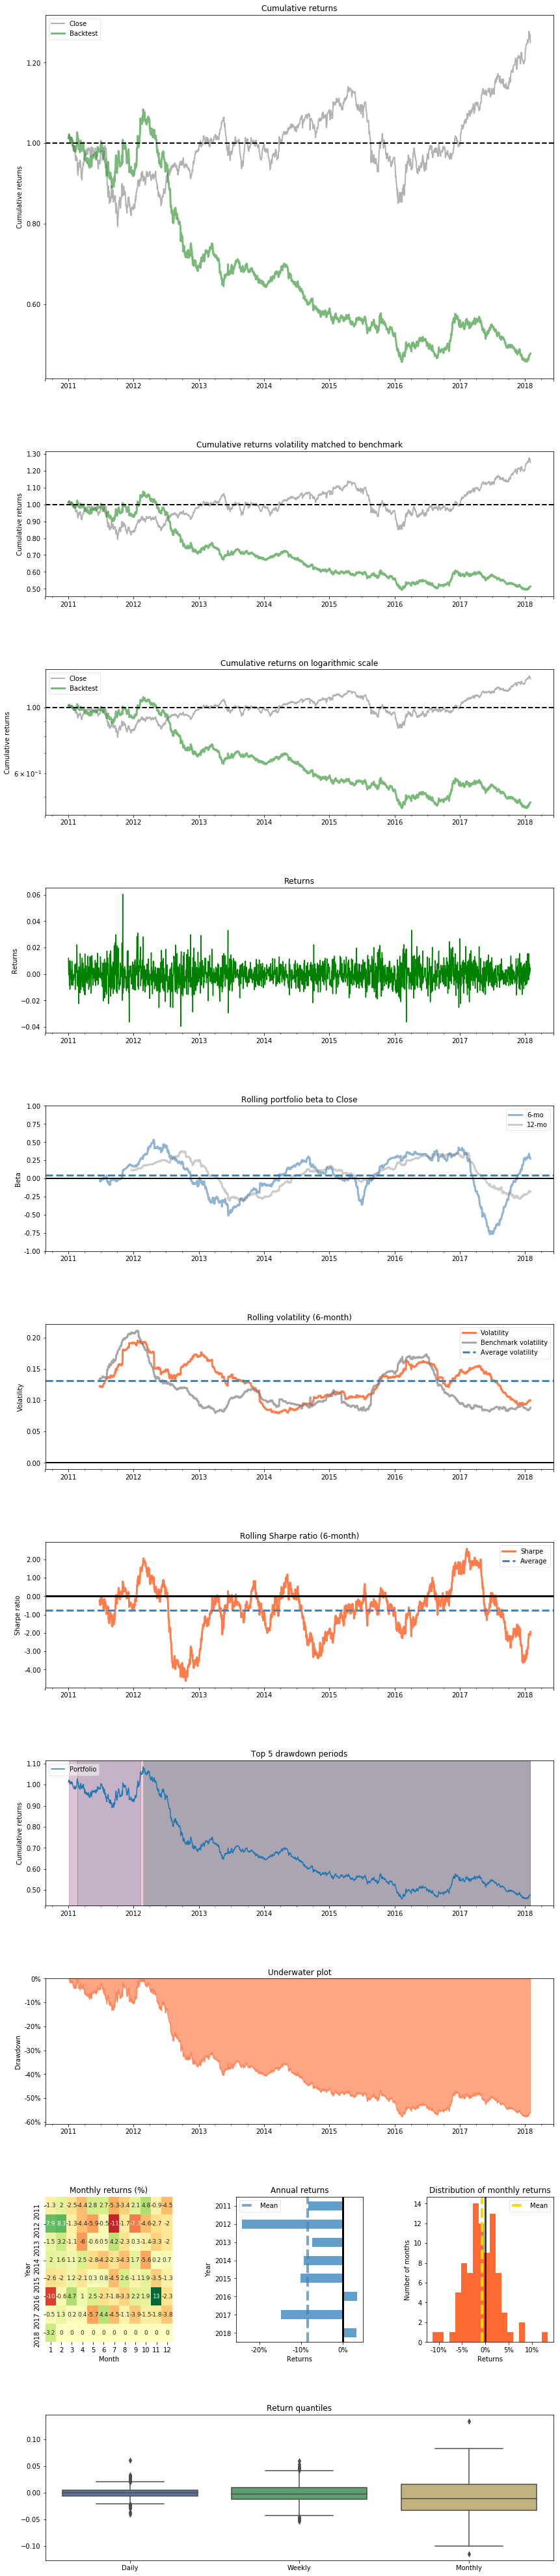

In [72]:
M2_1_6_returns = full_returns_dict_6M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_6_returns, benchmark_rets=sti_rets)

# Conclusion:

As we can see, the cross-sectional momentum strategy seems to have performed poorly for our backtest. Despite trying a range of parameters, we are unable to find a single strategy that can outperform a naive buy and hold. Therefore, we can rule out using the cross-sectional momentum anomaly strategy for STI stocks and reits.

In fact, for our chosen list of stocks, going long the worst performing stocks and going short the best performing stocks would have done much better!